In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

#from preprocesslib import preprocessEach, makeY

In [23]:
import os
import pandas as pd
import numpy as np

'''
이런식으로 사용하면 됩니다.
from preprocesslib import preprocessEach, makeY
X = preprocessEach('overlap')
X bootstrap해서 -> X_final만든 후에
y = makeY('overlap', len(X_final))
'''

def preprocessEach(folder_name):
   # set file path
    folder_path = f'/content/drive/MyDrive/research/data/{folder_name}_clean'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path)

        #preprocessing column
        df['open-close'] = df['Open'] - df['Close'] #추가
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df = df[['Close','Volume','Diff','open-close','MA5', 'Search']]
        # df = df[['Close','Volume','Diff','open-close', 'Search']]
        df.fillna(0, inplace=True)

        #log transform
        df = np.log1p(df)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

def makeY(folder_name, filelength):

    if folder_name=='growth':
        yGrowths = np.ones(filelength)
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yGrowths = np.zeros(filelength)
        yValues = np.ones(filelength)
    elif folder_name=='overlap':
        yGrowths = np.ones(filelength)
        yValues = np.ones(filelength)

    y = np.column_stack([yGrowths.T, yValues.T])
    return y

In [24]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

<ipython-input-23-53f3d4f93148>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
<ipython-input-23-53f3d4f93148>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
<ipython-input-23-53f3d4f93148>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)
<ipython-input-23-53f3d4f93148>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [25]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

diff = len(xValues) - len(xOverlaps)
xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [26]:
#make y values
yGrowths = makeY('growth', n_samples)
yValues = makeY('value', n_samples)
yOverlaps = makeY('overlap', n_samples)

In [27]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [28]:
x.shape

(3213, 1248, 6)

In [11]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [21]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [22]:
#model
model = Sequential()
model.add(LSTM(32, input_shape=(1248,6), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(2, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [13]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [ ]:
def cvsplitData(x,y, ind):
  x_test = x[ind]
  y_test = y[ind]
  cnt = 0
  for i in range(len(x)):
    if i!=ind:
      if cnt == 0:
        x_train = x[i]
        y_train = y[i]
        cnt += 1
      else:
        x_train = np.concatenate((x_train, x[i]))
        y_train = np.concatenate((y_train, y[i]))
  return x_train, x_test, y_train, y_test
  

In [16]:
#cross validation
# x_split, y_split = splitDataCrossVal(x, y)
# 위에 이게 아니라
X_train, X_test, Y_train, Y_test = splitData(x,y,0.8)
x_split, y_split = splitDataCrossVal(X_train, Y_train)
# 이게 아닌가,,



print(len(x_split))
accuracy_cross_val = []
for i in range(len(x_split)):
  x_train, x_test, y_train, y_test = cvsplitData(x_split, y_split, i)
  x_train = pad_sequences(x_train, dtype='float32')
  x_test = pad_sequences(x_test, dtype='float32')
  x_train = np.nan_to_num(x_train, nan=0)
  x_test = np.nan_to_num(x_test, nan=0)

  history=model.fit(x_train, y_train, epochs=2000, batch_size=128, validation_split=0.2, callbacks=[es, mc])
  model=load_model('best_model.h5')
  loss, accuracy = model.evaluate(x_test, y_test)
  accuracy_cross_val.append(accuracy)
print("cross validation accuracy:{}".format(accuracy_cross_val))
print("average cross validation accuracy:{}".format(sum(accuracy_cross_val)/len(accuracy_cross_val)))

3
Epoch 1/2000
6/6 [==============================] - 3s 76ms/step - loss: 0.6422 - acc: 0.6725 - val_loss: 0.6165 - val_acc: 0.6860
Epoch 2/2000
6/6 [==============================] - 0s 44ms/step - loss: 0.6389 - acc: 0.6447 - val_loss: 0.6082 - val_acc: 0.6802
Epoch 3/2000
6/6 [==============================] - 0s 46ms/step - loss: 0.6300 - acc: 0.5877 - val_loss: 0.5981 - val_acc: 0.5814
Epoch 4/2000
6/6 [==============================] - 0s 43ms/step - loss: 0.6219 - acc: 0.5307 - val_loss: 0.5913 - val_acc: 0.5872
Epoch 5/2000
6/6 [==============================] - 0s 42ms/step - loss: 0.6174 - acc: 0.5731 - val_loss: 0.5948 - val_acc: 0.5988
Epoch 6/2000
6/6 [==============================] - 0s 44ms/step - loss: 0.6182 - acc: 0.6243 - val_loss: 0.5847 - val_acc: 0.5988
Epoch 7/2000
6/6 [==============================] - 0s 49ms/step - loss: 0.6255 - acc: 0.6374 - val_loss: 0.6176 - val_acc: 0.7035
Epoch 8/2000
6/6 [==============================] - 0s 49ms/step - loss: 0.6574 -

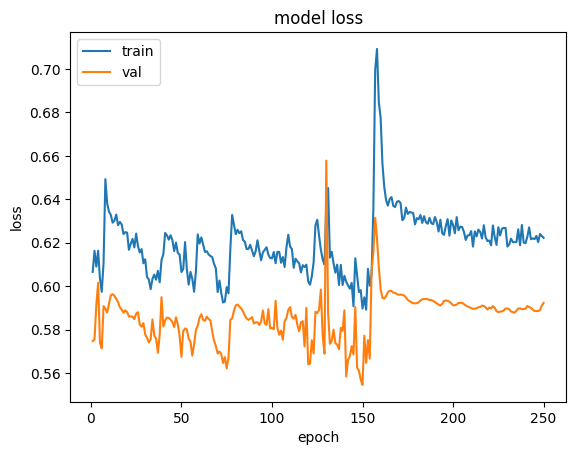

In [14]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

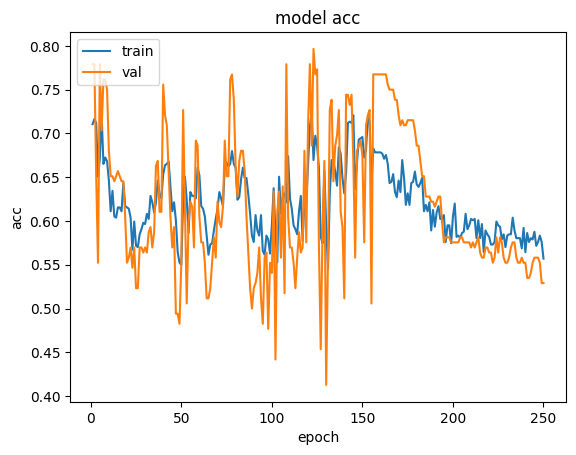

In [15]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()